# Yelp Review Sentiment Analysis



In [2]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from textblob import TextBlob
import matplotlib.pyplot as plt
import nltk
import gensim.downloader as api
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.matutils import corpus2csc
from sklearn.model_selection import train_test_split

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Upload training data from Drive

In [5]:
path = '/content/gdrive/My Drive/yelp_review_polarity_csv/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

Training data has two columns: A binary rating of sentiment (1 = negative, 2 = positive) and the review text.

In [6]:
train.head()
test.head()

,2,"Contrary to other reviews, I have zero complaints about the service or the prices. I have been getting tire service here for the past 5 years now, and compared to my experience with places like Pep Boys, these guys are experienced and know what they're doing. \nAlso, this is one place that I do not feel like I am being taken advantage of, just because of my gender. Other auto mechanics have been notorious for capitalizing on my ignorance of cars, and have sucked my bank account dry. But here, my service and road coverage has all been well explained - and let up to me to decide. \nAnd they just renovated the waiting room. It looks a lot better than it did in previous years."
0,1,Last summer I had an appointment to get new ti...
1,2,"Friendly staff, same starbucks fair you get an..."
2,1,The food is good. Unfortunately the service is...
3,2,Even when we didn't have a car Filene's Baseme...
4,2,"Picture Billy Joel's \""Piano Man\"" DOUBLED mix..."


In [7]:
print(train.shape)
print(test.shape)

(559999, 2)
(37999, 2)


The dataset is very large, so I decided to cut it down to 10,000 reviews. This number seemed standard for similar problems and provided reasonable runtimes.

In [8]:
trainArray = train.to_numpy()
testArray = test.to_numpy()
trainArray = trainArray[:10000,0:]

In [9]:
print(trainArray.shape)

(10000, 2)


# Feature Engineering
First I removed stopwords from the reviews to eliminate common yet uneccessary words like "a" or "the". I also removed any non-alphanumeric characters like punctuation marks.

In [10]:
trainArray_nostop = []
stopwords_ = set(stopwords.words('english'))

for current in trainArray:
    currentWord = current[1]
    tokens = word_tokenize(currentWord)
    noStopSentence = [w for w in tokens if w.isalnum() and not w.lower() in stopwords_]
    trainArray_nostop.append([current[0],noStopSentence])

Second I lemmatized the words to normalize tenses and remove other grammatical flourishes that do not fundamentally change the meaning of the word. This provided me with the root of every word.

In [11]:
stemmer = SnowballStemmer("english")
stemmedTrain = []

for sentence in trainArray_nostop:
  temp = [stemmer.stem(str(word)) for word in sentence[1]]
  stemmedTrain.append([sentence[0],temp])

Next I used TextBlob to get more detailed sentiment estimates of each review. TextBlob provides sentiment scores on a scale from -1 to 1, instead of the binary rating provided in the dataset. It also provides a subjectivity rating, which is an estimate of how much the sentiment rating is up to subjective interpretation.

In [12]:
for i,sentence in enumerate(stemmedTrain):
  wordsList = ' '.join(sentence[1])
  sent, subj = TextBlob(wordsList).sentiment
  stemmedTrain[i] = [sentence[0], sentence[1], sent, subj]

I plotted the TextBlob sentiments based on if they matched the binary sentiment rating (blue) or if they did not match (orange). TextBlob sentiments that were just slightly positive or negative were often incorrect, but more extreme sentiments were mostly accurate.

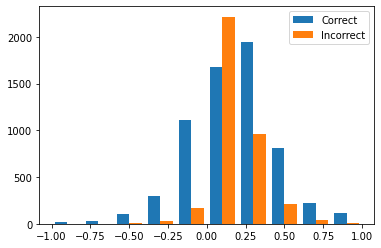

In [13]:
correct = []
incorrect = []
for x in stemmedTrain:
  label = x[0] - 1.5
  sent = x[2]
  if label >= 0 and sent >=0:
    correct.append(sent)
  elif label <= 0 and sent <=0:
    correct.append(sent)
  else:
    incorrect.append(sent)

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

_ = plt.hist([correct, incorrect], label=('Correct','Incorrect'))
plt.legend()


TextBlob gave many incorrect sentiment predictions so I did not end up using it in my model. However, I discuss at the end of this notebook how it could be used to improve the model.

Finally, I combined the features into a dataframe and saved it as a backup.

In [14]:
stemmedTrain = np.array(stemmedTrain)
text = []
for x in stemmedTrain[:,1]:
  text.append(' '.join(x))

trainDF = pd.DataFrame(stemmedTrain, columns=['yval', 'textlist',
                                                   'sentiment', 'subjectivity'])
trainDF['text'] = text

compression_opts = dict(method='zip', archive_name='out.csv')  
trainDF.to_csv('out.zip', index=False, compression=compression_opts)  

In [ ]:
trainDF = pd.read_csv('/content/gdrive/My Drive/out.zip')
trainDF = pd.DataFrame(trainDF)

# Converting from text to Bag of Words format
I looked for a library that could handle large datasets well since I was working with limited computing resources. I chose the GenSim library because I read that it does not need to store the full corpus in memory when doing operations.

In [15]:
text = [str(sentence).split() for sentence in trainDF['text']]

In [16]:
dic = Dictionary(text)

Converting the text to bag of words format allows the machine learning model to see text as a categorical matrix

In [17]:
corpus = [dic.doc2bow(sentence) for sentence in text]

I used the Tfidf representation, which increases the weight of words that appear frequently in a document, but decreases the weight of words which appear frequently in other documents in the corpus. This accounts for words which may be used often in the particular problem field and therefore may not be significant, even if they are frequent.

In [18]:
Tmodel = TfidfModel(corpus)

In [19]:
Tvector = Tmodel[corpus]

Here I saved the Tfidf corpus to my Drive as a backup.

In [20]:
from gensim.corpora.mmcorpus import MmCorpus
MmCorpus.serialize(corpus=Tvector, fname='corpus', id2word=dic)

In [ ]:
from gensim.corpora.mmcorpus import MmCorpus
Tvector = MmCorpus('/content/gdrive/My Drive/corpus')

At this point I had a transformed corpus object, which I then converted into a dense matrix. The GenSim function for converting a corpus object to a dense matrix puts the documents as columns, so I had to transpose the matrix before converting it into a pandas dataframe. That way each document was on a new row, which matches the training dataset.

In [21]:
from gensim.matutils import corpus2dense

In [22]:
csrr = corpus2dense(Tvector,len(dic)).transpose()

/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


In [24]:
df = pd.DataFrame(csrr)

I added the information I had previously gotten from the training dataset to the new dataframe. This includes: positive or negative sentiment label, review text in list form, TextBlob sentiment estimate, TextBlob subjectivity rating, and review text in string form.

In [26]:
col_name1 = 'yval'
col_name2 = 'textlist'
col_name3 = 'sentiment'
col_name4 = 'subjectivity'
col_name5 = 'text'

col1 = trainDF['yval']
col2 = trainDF['textlist']
col3 = trainDF['sentiment']
col4 = trainDF['subjectivity']
col5 = trainDF['text']

df.insert(0,col_name1,col1)
df.insert(1,col_name2,col2)
df.insert(2,col_name3,col3)
df.insert(3,col_name4,col4)
df.insert(4,col_name5,col5)

Here I saved the dataframe to my Drive as a backup.

In [ ]:
compression_opts = dict(method='zip', archive_name='out2.csv')  
df.to_csv('out2.zip', index=False, compression=compression_opts)

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/out2.zip')
df = pd.DataFrame(df)

# Model
I used an ensemble approach: I ran a Naive Bayes model on text and then used its predicted classification probabilities as a feature alongside the bag of words representation in a Gradient Boosting Classifier. I chose this apporach because I read that it was ideal for this problem, although with more time I would have liked to explore other options.

I initially ran a gridsearch using a Naive Bayes model and Tfidf representation to tune hyperparameters. One hyperparameter was minimum frequency, which removes words that appear at a frequency below the set minimum. These words would not be useful for training. The second hyperparameter was the value of alpha for additive smoothing. Increasing alpha translates to an increased probability that a positive or negative review would contain an arbitrary word x which is not in the training dataset. I used an ngram range of 2, which allows the model to look at groups of two words, instead of looking at the occurence of each word individually. Looking at other models for similar problems, it appeared that an ngram range of 2 generally produced the best performance, and therefore I decided I could safely assign that value without tuning.

In [27]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# train/test split 
X = trainDF['text'] 
y = trainDF['yval'] 
y = y.astype(int)
indices = trainDF.index

X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(X, y, indices, train_size = 0.8, random_state = 7)

In [28]:
# Naive Bayes Tfidf model
steps = [('vec', TfidfVectorizer(ngram_range = (1, 2))), ('nb', MultinomialNB())] 
pipeline = Pipeline(steps)
parameters = {'vec__min_df':[0.01, 0.1, 1, 10, 100], 'nb__alpha':[0.01, 0.1, 1, 10, 100]}
NBsearch = GridSearchCV(pipeline, parameters, cv = 10, scoring="accuracy") 
NBsearch.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vec',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': [0.01, 0.1, 1, 10, 100],
                         'vec__min_df': [0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [29]:
print(NBsearch.best_score_)

0.8690000000000001


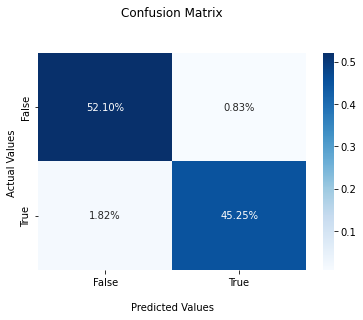

In [87]:
conma = cm(y, NBsearch.predict(X))
ax = sns.heatmap(conma/np.sum(conma), annot=True, cmap='Blues', fmt='.2%')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

I then took the predictions of the best model and inserted them as a feature into the dataframe. The predictions were in the form of probailities for each of the two classes (positive and negative), summing to 1 for each review in the dataset.

In [30]:
X_proba = pd.DataFrame(NBsearch.predict_proba(X), index = indices) 

In [31]:
# Bag of Words train/test split
X_bow = df.iloc[0:,5:] #get only columns containing bag of words features
y = df['yval'] 
y = y.astype(int)
indices = df.index

In [32]:
X_combined = pd.merge(X_bow, X_proba, left_index=True, right_index=True) 
Xtrain_combined, Xtest_combined, y_train, y_test, itrain, itest = train_test_split(X_combined,y,indices,train_size=0.8,random_state=7)

Using the new X dataframe containing the bag of words representations and the Naive Bayes predictions, I ran a gridsearch using a Gradient Boosting Classifier to find the ideal number of boosting stages (n_estimators) and learning rate.

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting Classifier model
steps = [('scaler', StandardScaler()), ('gbc', GradientBoostingClassifier(max_features='sqrt'))] 
pipeline = Pipeline(steps) 
parameters = {'gbc__n_estimators':[10, 50, 100, 200, 500], 'gbc__learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25]}
GBsearch = GridSearchCV(pipeline, parameters, cv = 10, scoring="accuracy") 

In [ ]:
GBsearch.fit(Xtrain_combined, y_train)

In [37]:
print(GBsearch.best_score_)

0.9984999999999999


This score is suspiciously high, although cross validation should prevent overfitting. If I had more time to imrpove the model I would explore this result further.

In [67]:
from sklearn.metrics import confusion_matrix as cm 

conmat = cm(y, GBsearch.predict(X_combined))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


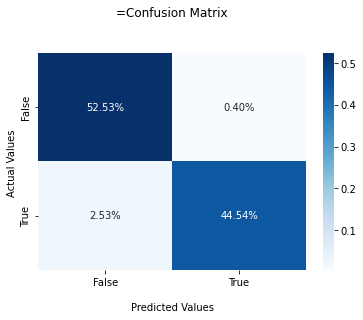

In [76]:
import seaborn as sns

ax = sns.heatmap(conmat/np.sum(conmat), annot=True, cmap='Blues', fmt='.2%')

ax.set_title('=Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

Judging by the graphs below, it appears that multiple different parameter combinations achieve similar scores. It also seems that the best results are converging at the top boundary of my parameters, suggesting that redoing the gridsearch with a larger range could yield better results.

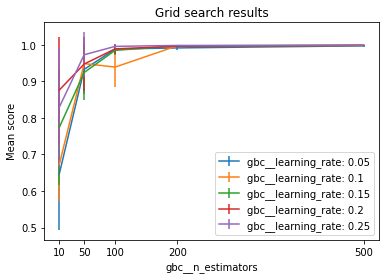

In [61]:
#!pip install sklearn_evaluation
from sklearn_evaluation import plot
grid_scores = GBsearch.cv_results_

plot.grid_search(grid_scores, change='gbc__n_estimators')

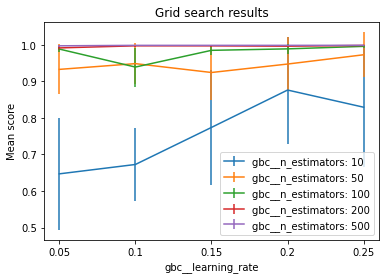

In [63]:
plot.grid_search(grid_scores, change='gbc__learning_rate')

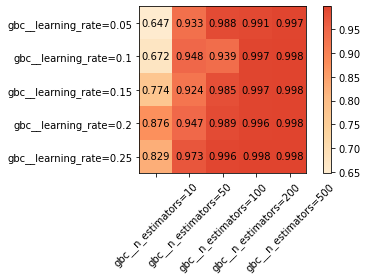

In [72]:
plot.grid_search(grid_scores, change=('gbc__n_estimators', 'gbc__learning_rate'))

In [38]:
print(GBsearch.best_params_)

{'gbc__learning_rate': 0.25, 'gbc__n_estimators': 500}


Finally, I fit the Gradient Boosting Classifier using the best performing parameters before running it on the test data to evaluate my model.

In [111]:
steps = [('scaler', StandardScaler()), ('gbc', GradientBoostingClassifier(learning_rate = 0.25, max_features = 'sqrt', n_estimators = 500))] 
GBbest = Pipeline(steps) 
GBbest.fit(Xtrain_combined, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Pipeline(steps=[('scaler', StandardScaler()),
                ('gbc',
                 GradientBoostingClassifier(learning_rate=0.25,
                                            max_features='sqrt',
                                            n_estimators=500))])

In [112]:
GBbest.score(Xtest_combined, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.874

The final score of my model was comparable with similar Yelp review sentiment analysis models, but there are still improvements I could implement with more time to improve performance:



*   Look for misspellings or abbreviations 
*   Use TextBlob sentiment predictions to determine magnitude of sentiment, and use provided labels to provide positive or negative value of sentiment. Could then train model to provide the magnitude of the sentiment as well as if it is positive or negative.
*   Do further analysis of the dataset to increase accuracy of low-magnitude reviews, which are harder to correctly categorize.
* I did not have time to test multiple different models, but with more time I may have been able to find a better model.
* Increase upper range of n_estimators in grid search. By manually inputting larger values for n_estimators, I was able to slightly increase the final score of my model, but running a new gridsearch with a wider range would take at least another day.
* Add additional models to the ensemble, and use a voting system to select the answer that the majority of models predict.


